<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Examen 02 - Manifold Learning</div><br>
    <div style="font-size: large; color:#FF0000">Francisco Javier Sáez Maldonado</div><br></div><hr>
</div>

**Configuración Inicial**

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Pregunta"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [69]:
import warnings
from sklearn.preprocessing import StandardScaler
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Callable, Optional, Union, Type
from sklearn.utils.extmath import svd_flip

# Datasets
from sklearn.datasets import make_blobs, make_swiss_roll, make_s_curve


# Kernels and utils
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import pairwise_distances
from sklearn.utils.extmath import svd_flip
from sklearn.gaussian_process.kernels import RBF as rbf_kernel
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering as SKL_SpectralClustering


from mpl_toolkits.mplot3d import Axes3D
Axes3D

matplotlib.rc('figure', figsize=(15, 5))

seed = 123
my_cmap = plt.cm.Spectral
scaler = StandardScaler()

warnings.filterwarnings('ignore')

# Directrices generales

Este notebook contiene el enunciado de la segunda parte del examen de *Métodos Funcionales en Aprendizaje Automático*.

Por favor, lee con cuidado cada uno de los tres ejercicios así como las preguntas que en ellos se formulan, y explica de manera concisa cada asunción y conclusión que hagas.

Debéis entregar un **informe** (que puede realizarse directamente sobre el notebook) y el **código** implementado para completar los ejercicios, así como las **referencias** consultadas en caso de necesidad. También se debe entregar el **código de honor firmado**. Todo esto se enviará vía Moodle en un *.zip*.

# Ejercicio 1 (3 puntos)

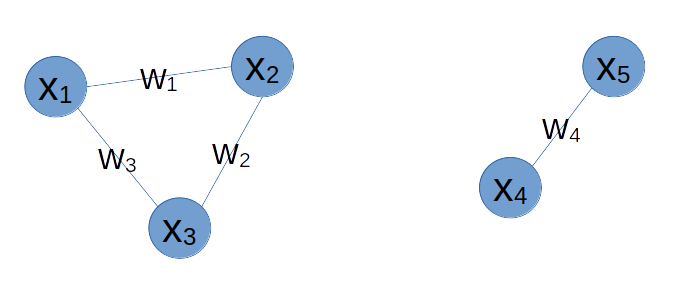

<div class="qst">

* Para el grafo anterior, calcula $f^\top L f$, siendo $L$ el laplaciano del grafo no normalizado ($L = D- W$) cuando $f$ se define como:
    $f(x_1) = 1, f(x_2) = 2, f(x_3) = 6, f(x_4) = 5, f(x_5) = 4$
  si los pesos del grafo son:
    $w_1 = 20, w_2 = 10, w_3 = 1, w_4 = 5$.
</div>

Dados estos pesos, debemos comenzar por escribir la matriz de pesos para su posterior implementación.  Asumimos que, puesto que no tenemos ninguna información, los pesos de la diagonal serán cero. Sabiendo esto, la matrix de adyacencia es la siguiente.
$$
W = \begin{pmatrix}
0 & w_1 & w_3 & 0 & 0 \\
w_1 & 0  & w_2 & 0 & 0 \\
w_3 & w_2 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & w_4 \\
0 & 0 & 0 & w_4 & 0
\end{pmatrix} = 
\begin{pmatrix}
0 & 20 & 1 & 0 & 0 \\
20 & 0  & 10 & 0 & 0 \\
1 & 10 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 5 \\
0 & 0 & 0 & 5 & 0
\end{pmatrix}
$$

Esta matriz de adyacencia puede definir un **vecindario** para los puntos que tenemos sobre una superficie (en Manifold Learning, asumimos que nuestro conjunto de datos está sobre una superficie de baja dimensión) y puede haber sido generado de varias formas (por ejemplo, usando una función de kernel). En este caso, no nos interesa de momento cómo ha sido generado, pues ya lo tenemos calculado.

Procedemos a implementarlo.

In [4]:
W = np.array([[0.0, 20.0, 1.0, 0.0, 0.0],
              [20.0, 0.0, 10.0, 0.0, 0.0],
              [1.0, 10.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 5.0],
              [0.0, 0.0, 0.0, 5.0, 0.0]])
f = np.array([1.0, 2.0, 6.0, 5.0, 4.0])

In [5]:
class LaplacianMatrix:

    def __init__(self,
                 W: np.ndarray,
                 method: str = 'unnormalized'):

        self.W = W
        self.D = np.diag(np.sum(W, axis=1))

        if method == 'unnormalized':
            self.L = self.D - self.W
        elif method == 'random_walk':
            self.L = np.identity(
                self.W.shape[0]) - np.linalg.inv(self.D)@self.W
        elif method == 'normalized':
            D_prime = np.sqrt(np.linalg.inv(self.D))
            self.L = np.identity(self.W.shape[0]) - D_prime @ self.W @ D_prime
        else:
            raise ValueError("Invalid method for Laplacian Matrix Computation")

    def optimal_f(self):
        # Compute eigenvalues and eigenvectors
        eig_vals, eig_vecs = np.linalg.eig(self.L)
        # Get index of sorting by eigenvalues
        idx = np.argsort(eig_vals)
        # Sort eigenvalues and eigenvectors
        s_vals = eig_vals[idx]
        s_vecs = eig_vecs[idx]
        # Obtain minimum eigenval > 0.0
        valid_idx = np.where(np.round(s_vals) > 0.0)[0]
        out = valid_idx[s_vals[valid_idx].argmin()]

        return np.round(s_vecs[out])

In [6]:
L = LaplacianMatrix(W)
print(f.T @ L.L @ f)

210.0


Recordamos que el Laplaciano no normalizado de un grafo es una matriz semidefinida positiva, esto es:
$$
J(f) = f^T \mathbf{L} f = \frac{1}{2}\sum_{i,j}^N w_{ij}(f_i - f_j)^2 \geq 0
$$
Para minimizar esta función, los valores que estén más cercanos en la superficie original (y por tanto tendrán valores más cercanos $f_i,f_j$), deberán tener pesos **mucho más altos** que los valores que se encuentren lejos en la superficie inicial (y por tanto, tendrán valores más dispares $f_i,f_j$). 

En este caso, y teniendo en cuenta que la forma cuadrática $J(f) = f^T \mathbf{L} f$ (también llamada error de reconstrucción) está acotada inferiormente por cero, podríamos decir que para esta función $f$, el Laplaciano no normalizado del grafo es una mala aproximación.

<div class="qst">

* Calcula $f^\top L f$ si cambiamos el valor de los pesos $w_1=1$ y $w_3=20$. ¿Cambia el resultado? ¿Por qué? 

</div>

Cambiamos ahora la matriz $W$ por una nueva matriz $W_2$.

In [7]:
W2 = np.array([[0.0, 1.0, 20.0, 0.0, 0.0],
              [1.0, 0.0, 10.0, 0.0, 0.0],
              [20.0, 10.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 5.0],
              [0.0, 0.0, 0.0, 5.0, 0.0]])

L2 = LaplacianMatrix(W2)
print(f.T @ L2.L @ f)

666.0


Obtenemos un valor más alto del error de reconstrucción. Observamos que, lo que se está haciendo a nivel de matriz es cambiar la posición $w_{12}$ por la $w_{13}$, y se hace lo mismo para las posiciones $w_{21}$ y $w_{31}$. Esto, en nuestro error de reconstrucción supone intercambiar las *importancias o pesos* ($w_{ij}$, asignadas usualmente según el nivel de *afinidad* entre $i$ y $j$) que se le dan a las diferencias $(f_1 - f_2)^2$ por la que se le dan a las diferencias $(f_1 - f_3)^2$. En este caso, basta fijarnos en estas diferencias
$$
(f_1 - f_2)^2 = 1, \quad (f_1 - f_3)^2 = 25
$$
Por lo que si asignamos una afinidad $w_{ij}$ más alta a dos puntos que tengan mucha más distancia entre sus valores de $f$, como **es el caso entre los puntos $x_1$ y $x_3$** y es lo que **hemos hecho al intercambiar los valores**, entonces estamos **usando una matriz de afinidad que representa peor** la afinidad real entre nuestros datos.

<div class="qst">

* Define una función $f$ que minimice $f^\top L f$. ¿Existe más de una solución que minimice $f^\top L f$ , sin tener en cuenta múltiplos de la $f$ definida (de manera más formal, que sea linealmente independiente a la solución dada)? 

</div>

Claramente, sabemos que la función $f \equiv 0$ minimiza esta forma cuadrática. Sin embargo, esta solución trivial no es interesante así que buscaremos soluciones diferentes.

Sabemos que la función $f$ que minimiza $f^T L f$ se puede obtener analíticamente. Esto está hecho en las transparencias de teoría mediante el uso del lagrangiano del problema de minimización:
\begin{align*}
& \text{arg}\min_y \{\mathbf{f}^T L \mathbf{f}\}\\
& s.t. \  \mathbf{f}^T \mathbf{D} \mathbf{f} = 1.
\end{align*}
Se sabe que el mínimo es **el vector propio** correspondiente al **menor valor propio de $L$ no negativo**.

Podemos calcular esto usando la función `optimal_f` que hemos definido en la clase `LaplacianMatrix`.

In [8]:
print("The optimal f for the first L is")
print(L.optimal_f())
print("The optimal f for the second L is")
print(L2.optimal_f())

The optimal f for the first L is
[0. 0. 0. 1. 1.]
The optimal f for the second L is
[0. 0. 0. 1. 1.]


Podemos observar que la función $f$ óptima es la misma para los dos casos anteriores. Podemos comprobar además que el valor de reconstrucción es cero para estos vectores:

In [9]:
print("Reconstruction error for first L")
print(L.optimal_f().T @ L.L @ L.optimal_f())
print("Reconstruction error for second L")
print(L2.optimal_f().T @ L2.L @ L2.optimal_f())

Reconstruction error for first L
0.0
Reconstruction error for second L
0.0


Por último, se nos pregunta si existen soluciones para este error de reconstrucción que sean **linealmente independientes** a la obtenida por el método de la minimización. En efecto, basta observar las matrices $L$:

In [10]:
print("L")
print(L.L)
print("L2")
print(L2.L)

L
[[ 21. -20.  -1.   0.   0.]
 [-20.  30. -10.   0.   0.]
 [ -1. -10.  11.   0.   0.]
 [  0.   0.   0.   5.  -5.]
 [  0.   0.   0.  -5.   5.]]
L2
[[ 21.  -1. -20.   0.   0.]
 [ -1.  11. -10.   0.   0.]
 [-20. -10.  30.   0.   0.]
 [  0.   0.   0.   5.  -5.]
 [  0.   0.   0.  -5.   5.]]


Se observa que en ambos casos, todas las filas suman cero, por lo que bastaría tomar $f = (1,1,1,0,0)$ (sumar en $f^t \mathbf{L}$ los tres primeros elementos), que es claramente linealmente independiente al anterior, y se obtiene que esta función $f$ también minimiza el error de reconstrucción:

In [11]:
f2_indep = np.array([1.0, 1.0, 1.0, 0.0, 0.0])
print("Reconstruction error for first L")
print(f2_indep.T @ L.L @ f2_indep)
print("Reconstruction error for second L")
print(f2_indep.T @ L2.L @ f2_indep)

Reconstruction error for first L
0.0
Reconstruction error for second L
0.0


# Ejercicio 2 (4 puntos)

Un algoritmo muy utilizado tanto en el ámbito de manifold learning, como en clustering o en análisis de grafos (por ejemplo para detectar comunidades) es el método de **Spectral Clustering**.
Durante las clases del curso no nos ha dado tiempo a profundizar en él, por lo que vamos a utilizarlo para resolver un problema.

<div class="qst">

* Define una clase **Spectral Clustering**, así como sus funciones fit y fit-transform (no vamos a permitir en este caso la aplicación del método a puntos nuevos fuera de la muestra inicial).
     
* El algoritmo de Spectral Clustering a implementar será el basado en el laplaciano de camino aleatorio, es decir, $L_{rw}=I − D^{−1}W$.
</div>

Implementamos la clase de la forma más genérica posible. De hecho, se comentan las siguientes consideraciones:

#### Métodos fit y transform

Según [la documentación de Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) para `SpectralClustering`, este es un método de clustering, así que asumimos que nuestra clase deberá hacer clustering. Sin embargo, lo más relevante no será esto, sino que serán los **embeddings** obtenidos mediante un método Laplaciano. 

Es por ello que nuestros métodos `fit` y `fit_transform` se comportarán como lo haría un algoritmo de clustering, es decir, `fit_transform` nos devolverá los clusters predichos para la entrada. Sin embargo, guardaremos tanto la matriz de afinidad como las proyecciones deseadas (embeddings) pues es lo que realmente nos interesará para las visualizaciones.

Por simplicidad, el método de clustering elegido ha sido `KMeans`.

#### Kernels y matrices de afinidad

Para calcular la matriz de afinidad sabemos que podemos realizar dos acciones principalmente:

- Utilizar **KNN** para crear una matriz del grafo en la que  $w_{ij} = k$ si, y solo si, $i$ y $j$ son vecinos próximos en KNN. El valor $k$ dependerá de si la relación de vecindad entre $i$ y $j$ es simétrica.

- Utilizar los kernels más estándar, como son `rbf` y `laplacian`. En este caso, nuestra clase recibirá **el parámetro** $\sigma$ de cadar kernel

- Utilizar un `Callable` (una función) como kernel.

#### Matriz Laplaciana

Para el cálculo de la matriz laplaciana, se han implementado en la clase `LaplacianMatrix` las tres maneras mostradas en las diapositivas de calcular la matriz laplaciana, siendo estas:

- No normalizada, $\mathbf{L = D - W}$, pues ya la usábamos en el primer ejercicio
- **Random Walk** o **camino aleatorio**, que es la que se nos pide, con $\mathbf{L_{rw} = I - D^{-1}W}$
- Normalizada, sabiendo que viene dada por $\mathbf{L}_N = \mathbf{I - D^{-1/2} W D^{-1/2}}$

In [137]:
class SpectralClustering(TransformerMixin, BaseEstimator):
    """
        Spectral Clustering class implementation.
        Sklearn like.
        In this class, fitting the data is computing the eigenvectors and
        eigenvalues of the spectral method, and also fitting
    """

    def __init__(self,
                 kernel: Union[str, Callable[[
                     np.ndarray, np.ndarray], np.ndarray]] = 'rbf',
                 sigma: Union[str, float] = 'percentile',
                 n_components: int = 2,
                 percentile: float = 50,
                 laplacian_method: str = 'random_walk',
                 n_clusters: int = 8,  # Default number of classes in swiss roll
                 k_neighbors: int = 5
                 ):
        """
        Initializes the Spectral Clustering object
         ----------
        kernel : kernel function to compute affinity matrix. 
                Can be 'rbf', 'laplacian' or a callable
        sigma : Sigma to apply to the kernel
        n_components: number of components to keep after projection
        percentile: percentile (0 to 100) used to compute sigma if needed
        laplacian_method: method used to compute the laplacian. Can be
                          'unnormalized', 'random_walk', 'normalized' or 'knn'
        n_clusters: number of clusters to use in the clustering phase


        Returns
        -------
        self : returns an instance of self.
        """
        # Assignment of the hyper-parameters
        self.sigma = sigma
        self.n_components = n_components
        self._kernel = kernel
        self.percentile = percentile
        self.laplacian_method = laplacian_method
        self.n_clusters = n_clusters
        self.k_neighbors = k_neighbors

        # Raise variables
        self._fitted = False
        self._fixed_sigma = False

    def _determine_sigma(self):
        """
        Converts string sigma values to actual float sigma values
        """
        if self.sigma == 'median':
            self.sigma = np.percentile(pairwise_distances(self.X), 50)
        elif self.sigma == 'maximum':
            self.sigma = np.percentile(pairwise_distances(self.X), 100)
        elif self.sigma == 'percentile':
            self.sigma = np.percentile(
                pairwise_distances(self.X), self.percentile)

        self._fixed_sigma = True

    def _determine_kernel(self):
        """
        Converts kernel value to final kernel
        """
        if not self._fixed_sigma:
            raise ValueError("Sigma has not been fixed yet")

        if self._kernel in ['auto', 'rbf']:
            # Recall that this rbf_kernel is the one from
            # Gaussian procesess, which receives sigma as parameter
            self._kernel = rbf_kernel(self.sigma)

        elif self._kernel == 'laplacian':
            self._kernel = lambda X, y = None: laplacian_kernel(
                X, y, gamma=1/(2*self.sigma**2))

        # We create a kernel that is KNN applied to our data
        elif self._kernel == 'knn':
            # Define symmetrize function to symmetrize KNN graph
            def symmetrize(X): return (X + X.T)/2.0
            self._kernel = lambda X, y = None: symmetrize(kneighbors_graph(X,
                                                                           self.k_neighbors,
                                                                           mode='connectivity',
                                                                           include_self=True).toarray())

    def fit(self, X, y=None):
        """
        Computes the embedding vectors for data X and then cluste
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        self : returns an instance of self.
        """
        # Save data
        self.X = X

        # Determine sigma to use
        self._determine_sigma()
        self._determine_kernel()

        # Instantiate the kernel and compute the affinity matrix
        # The kernel can be knn adjacency graph
        self.W = self._kernel(X)
        self.affinity_matrix_ = LaplacianMatrix(
            self.W, method=self.laplacian_method).L

        # Obtain the SVD decomposition of the conjugate matrix
        # Remember that eigenvecs has the eigen-vectors as its columns!
        eigenvecs, eigenvals, V = np.linalg.svd(
            self.affinity_matrix_, full_matrices=True)

        # Make the eigenvector signs match the ones obtained from Sklearn
        eigenvecs, _ = svd_flip(eigenvecs, V)

        eigenvecs = np.flip(eigenvecs, axis=1)
        eigenvals = np.flip(eigenvals)

        # Remove first component, with eigenvalue 1
        # Recall that we are assuming that the eigenvals/vecs are sorted!
        # n_components + 1 since we are already not considering 1st position
        self.eigenvecs = eigenvecs[:, 1:self.n_components + 1]
        self.eigenvals = eigenvals[1:self.n_components + 1]

        # Fit Kmeans to eigenvecs
        self.kmeans = KMeans(n_clusters=self.n_clusters,
                             random_state=0).fit(self.eigenvecs)

        # Update fitted state
        self._fitted = True
        return self

    def fit_transform(self, X, y=None):
        """Compute the embedding vectors for data X and transform X.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        self.fit(X)
        return self.kmeans.transform(self.eigenvecs)

Definimos las siguientes funciones de plot que serán útiles más adelante.

In [143]:
def scatter_2D(X, y, title="", equal_axis=False, ax=None, hide_ticks=False):
    if ax == None:
        fig = plt.figure()
        ax = fig.add_subplot()
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
    if equal_axis:
        ax.axis('equal')
    ax.set_title(title)

    # Hide ticks if needed
    if hide_ticks:
        ax.set_yticklabels([])
        ax.set_xticklabels([])

    # If single figure
    if ax == None:
        plt.show()


def scatter_3D(X, y, title=""):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=my_cmap)
    ax.set_title(title)
    ax.view_init(26,51)
    plt.show()

Tras realizar la implementación, queremos probar cómo funciona esta en un conjunto de datos de prueba. Podemos usar cualquiera de los usados en prácticas de la asignatura, así que elegimos `S_curve`.

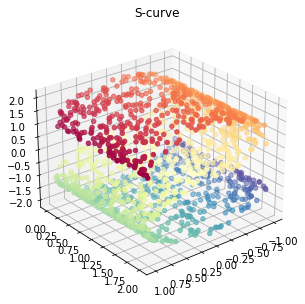

In [144]:
N = 1500
X, color = make_s_curve(N, random_state=seed)

scatter_3D(X,color,title = "S-curve")

Se considera que la parte más interesante de este algoritmo es la parte de **creación del embedding**, es decir, la creación de la matriz laplaciana, la extracción de valores y vectores propios y la selección de componentes con menores valores propios. Sabemos que las tareas posteriores verán su rendimiento afectado por el embedding generado, así que para las pruebas prestaremos atención a estos embeddings.

Puesto que `sklearn` es la librería de referencia, haremos una comparativa de los embeddings obtenidos tanto por nuestra clase (recordemos que el objetivo final de nuestra clase no es obtener el embedding sino los clusters) como por la clase `SpectralClustering` de `sklearn`.

Para poder hacer una comparación clara, tratamos de usar los mismos parámetros en ambas clases. Hemos visto en la documentación que en `Sklearn` se usa por defecto el **laplaciano normalizado**, con kernel `'rbf'` de parámetro $\gamma = 1.0$. Es por ello que nosotros debemos usar este mismo laplaciano, y el kernel `'rbf'`  de parámetro $\sigma = \sqrt{\frac{1}{2\gamma}}$.

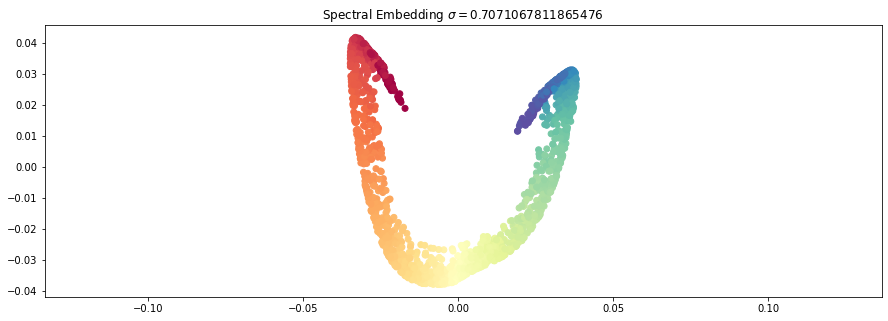

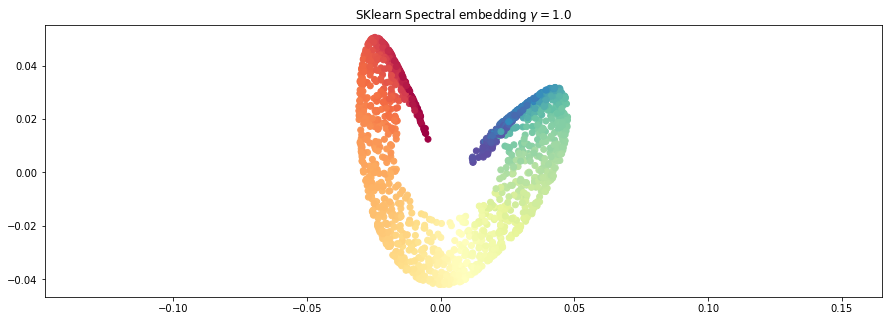

In [118]:
# Default sklearn gamma
gamma = 1.0
# Correspondence sigma-gamma
sigma = np.sqrt(1/(2*gamma))
sc = SpectralClustering(sigma=sigma, laplacian_method='normalized')
X_red = sc.fit_transform(X)

scatter_2D(sc.eigenvecs, color, title=r"Spectral Embedding $\sigma = {}$".format(
    sc.sigma), equal_axis=True)

sc_skl = SKL_SpectralClustering(gamma=gamma, n_components=2)
X_red_sk = sc_skl.fit(X)

eigenvecs, eigenvals, V = np.linalg.svd(
    sc_skl.affinity_matrix_, full_matrices=True)


eigenvecs, _ = svd_flip(eigenvecs, V)
eigenvecs = eigenvecs[:, 1:3]


scatter_2D(eigenvecs, color, title="SKlearn Spectral embedding $\gamma = {}$".format(
    gamma),  equal_axis=True)

Se puede observar que el resultado es bastante similar aunque no completamente idéntico. Hemos tratado de detectar cuál es la diferencia entre nuestro código y el de Sklearn, encontrando que la diferencia principal se encuentra en cómo se calcula matriz $L$ que, aunque sabemos que es el laplaciano normalizado, se realizan una serie de transformaciones y operaciones para aumentar la robustez en general del método, lo cual ocasiona resultados finales de la matriz ligeramente diferentes que resultan luego en vectores propios diferentes.

<div class="qst">

* ¿Qué diferencias aprecias entre este algoritmo y *Diffusion Maps*?
    
</div>

<div class="qst">

* Aplica el algoritmo definido al siguiente conjunto de datos.

    * ¿Se obtiene un buen resultado?

    * ¿Cómo has realizado la selección de hiperparámetros involucrados?
    
</div>

Comenzamos representando ciertas propiedades de los datos, así como los mismos en $2D$ y $3D$.

Shape:
(100, 12)
Unique labels:
[0. 1.]


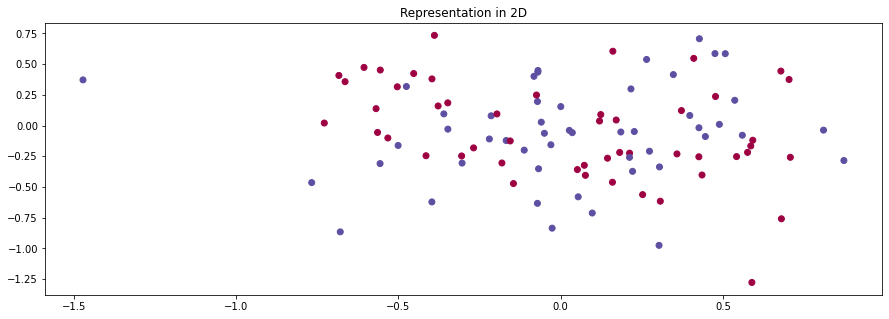

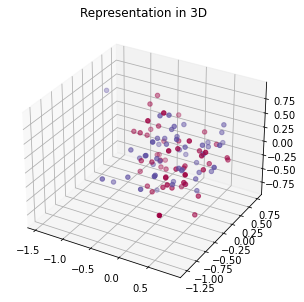

In [120]:
data = np.loadtxt('data.txt')
X=data[:,:-1]
y=data[:,-1]
print("Shape:")
print(X.shape)
print("Unique labels:")
print(np.unique(y))
scatter_2D(X,y, title = "Representation in 2D")
scatter_3D(X,y, title = "Representation in 3D")

Vemos que no se observa a priori en estos datos ninguna estructura de superficie en $2D$ ni en $3D$, y sabemos que los métodos que estamos utilizando están pensados para usarlos sobre Variedades (Manifold), por lo que podría darse que el método no produjese buenos resultados para estos datos.

Vamos a realizar una búsqueda variando diferentes parámetros para tratar de observar si podemos encontrar algunos que nos den buenos resultados. Sabemos que, en los métodos espectrales sobre variedades, la selección de hiperparámetros es crucial para obtener buenos resultados. 

### Usando Kernel RBF

Comenzamos la experimentación usando como forma de calcular la matriz de adyacencia $W$ utilizando el kernel RBF. Para este kernel tenemos el parámetro $\sigma$, que tendremos que variar para ver si obtenemos algún buen resultado.

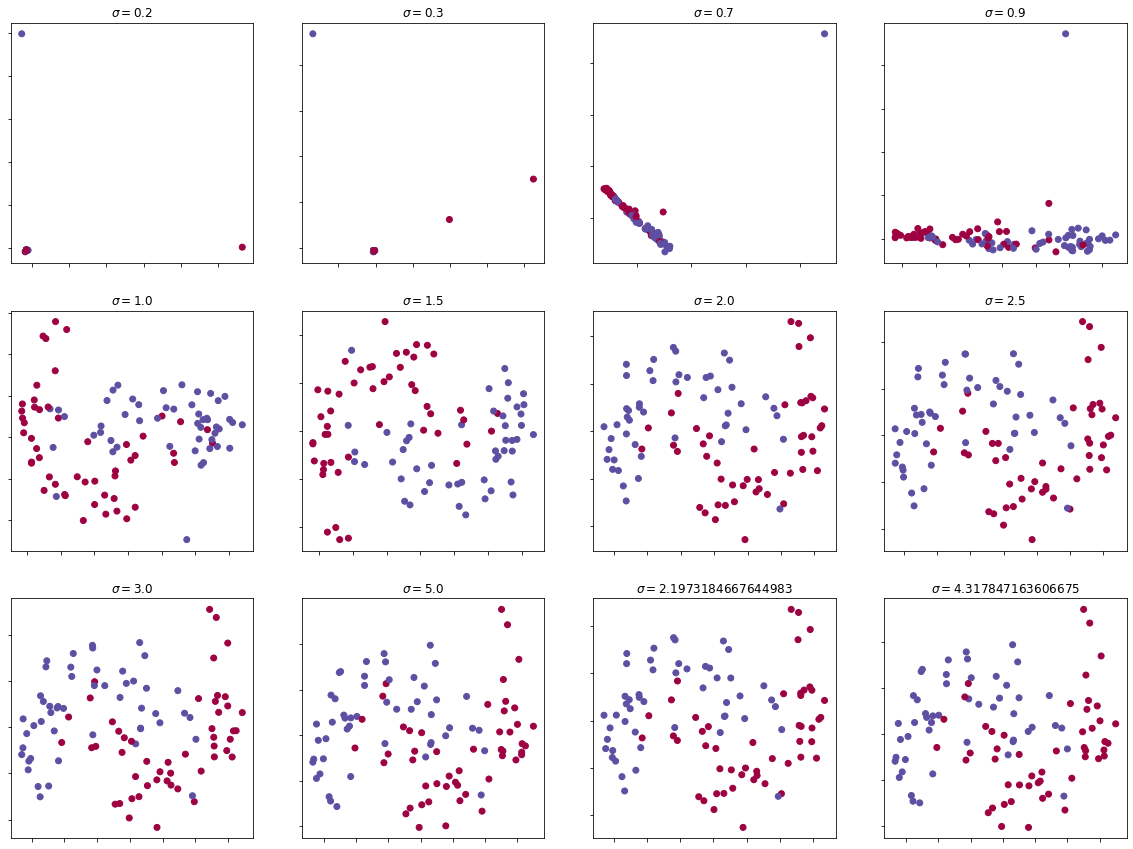

In [124]:
sigmas = [0.2, 0.3, 0.7,
         0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0, 'median', 'maximum']
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
for i, sigma in enumerate(sigmas):
    sc = SpectralClustering(sigma=sigma)
    X_iter = sc.fit_transform(X)
    scatter_2D(sc.eigenvecs,
               y,
               title=r"$\sigma = {}$".format(sc.sigma),
               ax=axes[i//4][i % 4],
               hide_ticks=True)

En general, se observa que mayores valores de $\sigma$ nos proporcionan una separación "algo mejor" de nuestros datos. Sin embargo, no hemos podido encontrar ningún $\sigma$ para el cual nuestros datos queden completamente separados.

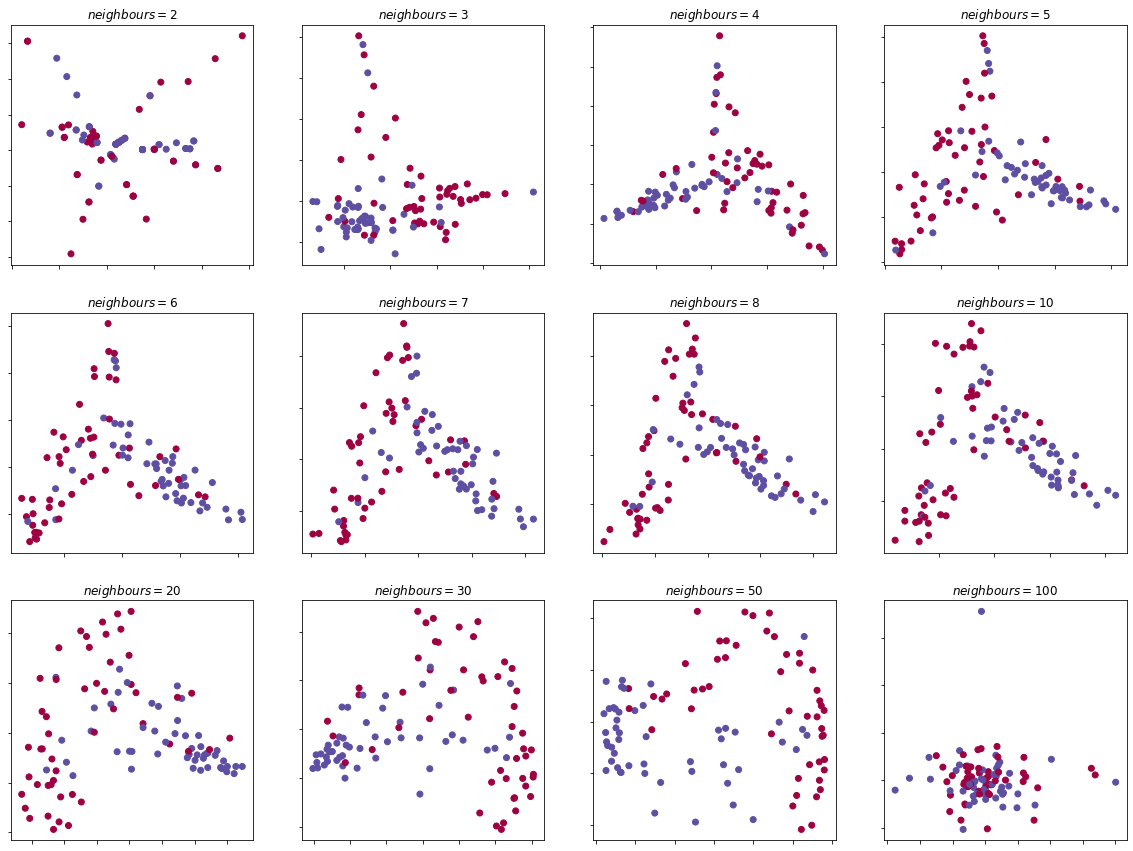

In [138]:
n_neighbors = [2, 3, 4, 5,
               6, 7, 8, 10,
               20, 30, 50, 100]
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
for i, n in enumerate(n_neighbours):
    sc = SpectralClustering(kernel='knn', k_neighbors=n)
    X_iter = sc.fit_transform(X)
    scatter_2D(sc.eigenvecs,
               y,
               title=r"$neighbours = {}$".format(n),
               ax=axes[i//4][i % 4],
               hide_ticks=True)

# Ejercicio 3 (3 puntos)

Hasta ahora hemos visto cómo trabajar con una matriz de datos que transformamos en un grafo para aplicar un método de reducción de dimensión espectral, pero todos los algoritmos que hemos vistos podrían aplicarse directamente a un *grafo* con cierta información. Para este ejercicio vamos a trabajar con el grafo del *club de karate de Zacarías* (un ejemplo clásico en teoría de grafos).

Para leer los datos necesitaréis instalar la librería *igraph* y *cairo*, para lo que podéis usar los comandos:<code>
    pip install python-igraph
    pip install pycairo
</code>
Y si os da error porque faltan librerías deberéis instalar:
<code>
    sudo apt install libcairo2-dev
    sudo apt install python3-dev
</code>

Veamos primero que pinta tienen los datos:

In [18]:
from igraph import *

g=Graph.Read_GML("karate.gml")
summary(g)

# Información de una arista    
print(g.es[0])
# Acceso a la información del primer nodo del grafo
print(g.vs[g.es[0].tuple[0]])
# Acceso a la información del segundo nodo del grafo
print(g.vs[g.es[0].tuple[1]])

ModuleNotFoundError: No module named 'igraph'

El siguiente código permite visualizar el grafo dado.
En este caso permitimos que se seleccione de manera automática el mejor algoritmo de visualización, etiquetamos los nodos por su identificador y lo coloreamos (todo del mismo color pues a priori no conocemos las comunidades).

In [ ]:
layout = g.layout("auto")
g.vs["label"] = [int(idx) for idx in g.vs["id"]]
plot(g, layout=layout, bbox=(0, 0, 300, 300))

<div class="qst">

* Obten la matriz de pesos del grafo a partir de los datos dados usando la librería igraph proporcionada.

</div>

<div class="qst">

* Aplica el algoritmo de Spectral Clustering de manera que se observen lo mejor posible las dos comunidades existentes en el grafo.

</div>